<script src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS_HTML"></script>

In [42]:
# !git clone https://github.com/roeeSch/data_exercise.git

### Import necessary packages:

In [43]:
import numpy as np
import pandas as pd
import skimage.measure

from matplotlib import pyplot as plt

### Import local packages

In [44]:
all_data = True
analysis = False

try:
    # for colab
    from data_exercise.utils import ls2pc, ls2ft, calc_lin_char
    workdir = 'data_exercise'
except ModuleNotFoundError as e:
    # for local
    from utils import ls2pc, ls2ft, calc_lin_char
    workdir = '.'

### Load recording from csv file

In [45]:
# Load csv:
file_name, lookingUp = workdir + '/rec_08c.csv', False
table = pd.read_table(file_name, delimiter=',')

table.iloc[:3]

,Unnamed: 0,tick,stateEstimate.x,stateEstimate.y,stateEstimate.yaw,mr18.m0,mr18.m1,mr18.m2,mr18.m3,mr18.m4,...,mr18.m6,mr18.m7,mr18.m8,mr18.m9,mr18.m10,mr18.m11,mr18.m12,mr18.m13,mr18.m14,mr18.m15
0,0,0.0,0.114816,0.059077,1.386655,749.0,930.0,1595.0,2210.0,5002.0,...,841.0,634.0,5002.0,2199.0,1014.0,1269.0,1202.0,1302.0,1010.0,801.0
1,1,30.0,0.115445,0.061060,1.430263,768.0,913.0,1500.0,2149.0,5002.0,...,838.0,653.0,5002.0,5001.0,1012.0,1275.0,1186.0,1277.0,1021.0,807.0
2,2,40.0,0.115674,0.061063,1.450047,766.0,879.0,1526.0,5002.0,5002.0,...,832.0,650.0,5002.0,2120.0,1025.0,1265.0,1202.0,1309.0,1016.0,796.0


**Columns are:**
1. tick is the time column (in milliseconds)
2. stateEstimate.x and stateEstimate.y are the (x,y) coordinates of spot in meters.
3. stateEstimate.yaw is spots orientation in degrees.
4. The fields {mr18.m0, mr18.m1, ..., mr18.m15} are the range measurements in millimeters. Ranges above 4000 are measurement errors.


#### Convert recorded data into desired physical units:

In [46]:

time = table['tick'].to_numpy()
time -= time[0]
Ts = np.median(np.diff(time, 1))
print(f'original Ts={Ts} [ms], time is [{time[0]},{time[-1]}]')

ranges = table[[f'mr18.m{i}' for i in range(16)]].to_numpy(dtype=float)*0.001
x = table['stateEstimate.x'].to_numpy()
y = table['stateEstimate.y'].to_numpy()

# unwrap angle:
t = np.unwrap(np.deg2rad(table['stateEstimate.yaw'].to_numpy()))
print(f'ranges shape before reduction: {ranges.shape}')

original Ts=10.0 [ms], time is [0.0,284290.0]
ranges shape before reduction: (20023, 16)


#### Down-sample
If needed (computations are faster with less data), downsample the recording

In [47]:

# down-sample:
D = 1
if D>1:
    ranges = skimage.measure.block_reduce(ranges, (D,1), np.max)
    print(f'ranges shape after D=({D},1) reduction: {ranges.shape}')
    x = skimage.measure.block_reduce(x, (D,), np.median)
    y = skimage.measure.block_reduce(y, (D,), np.median)
    t = skimage.measure.block_reduce(t, (D,), np.median)
    time = skimage.measure.block_reduce(time, (D,), np.max)

Ts = np.median(np.diff(time, 1))
print(f'downsampled Ts={Ts} [ms]')

downsampled Ts=10.0 [ms]


#### Plot the x,y coordinates:

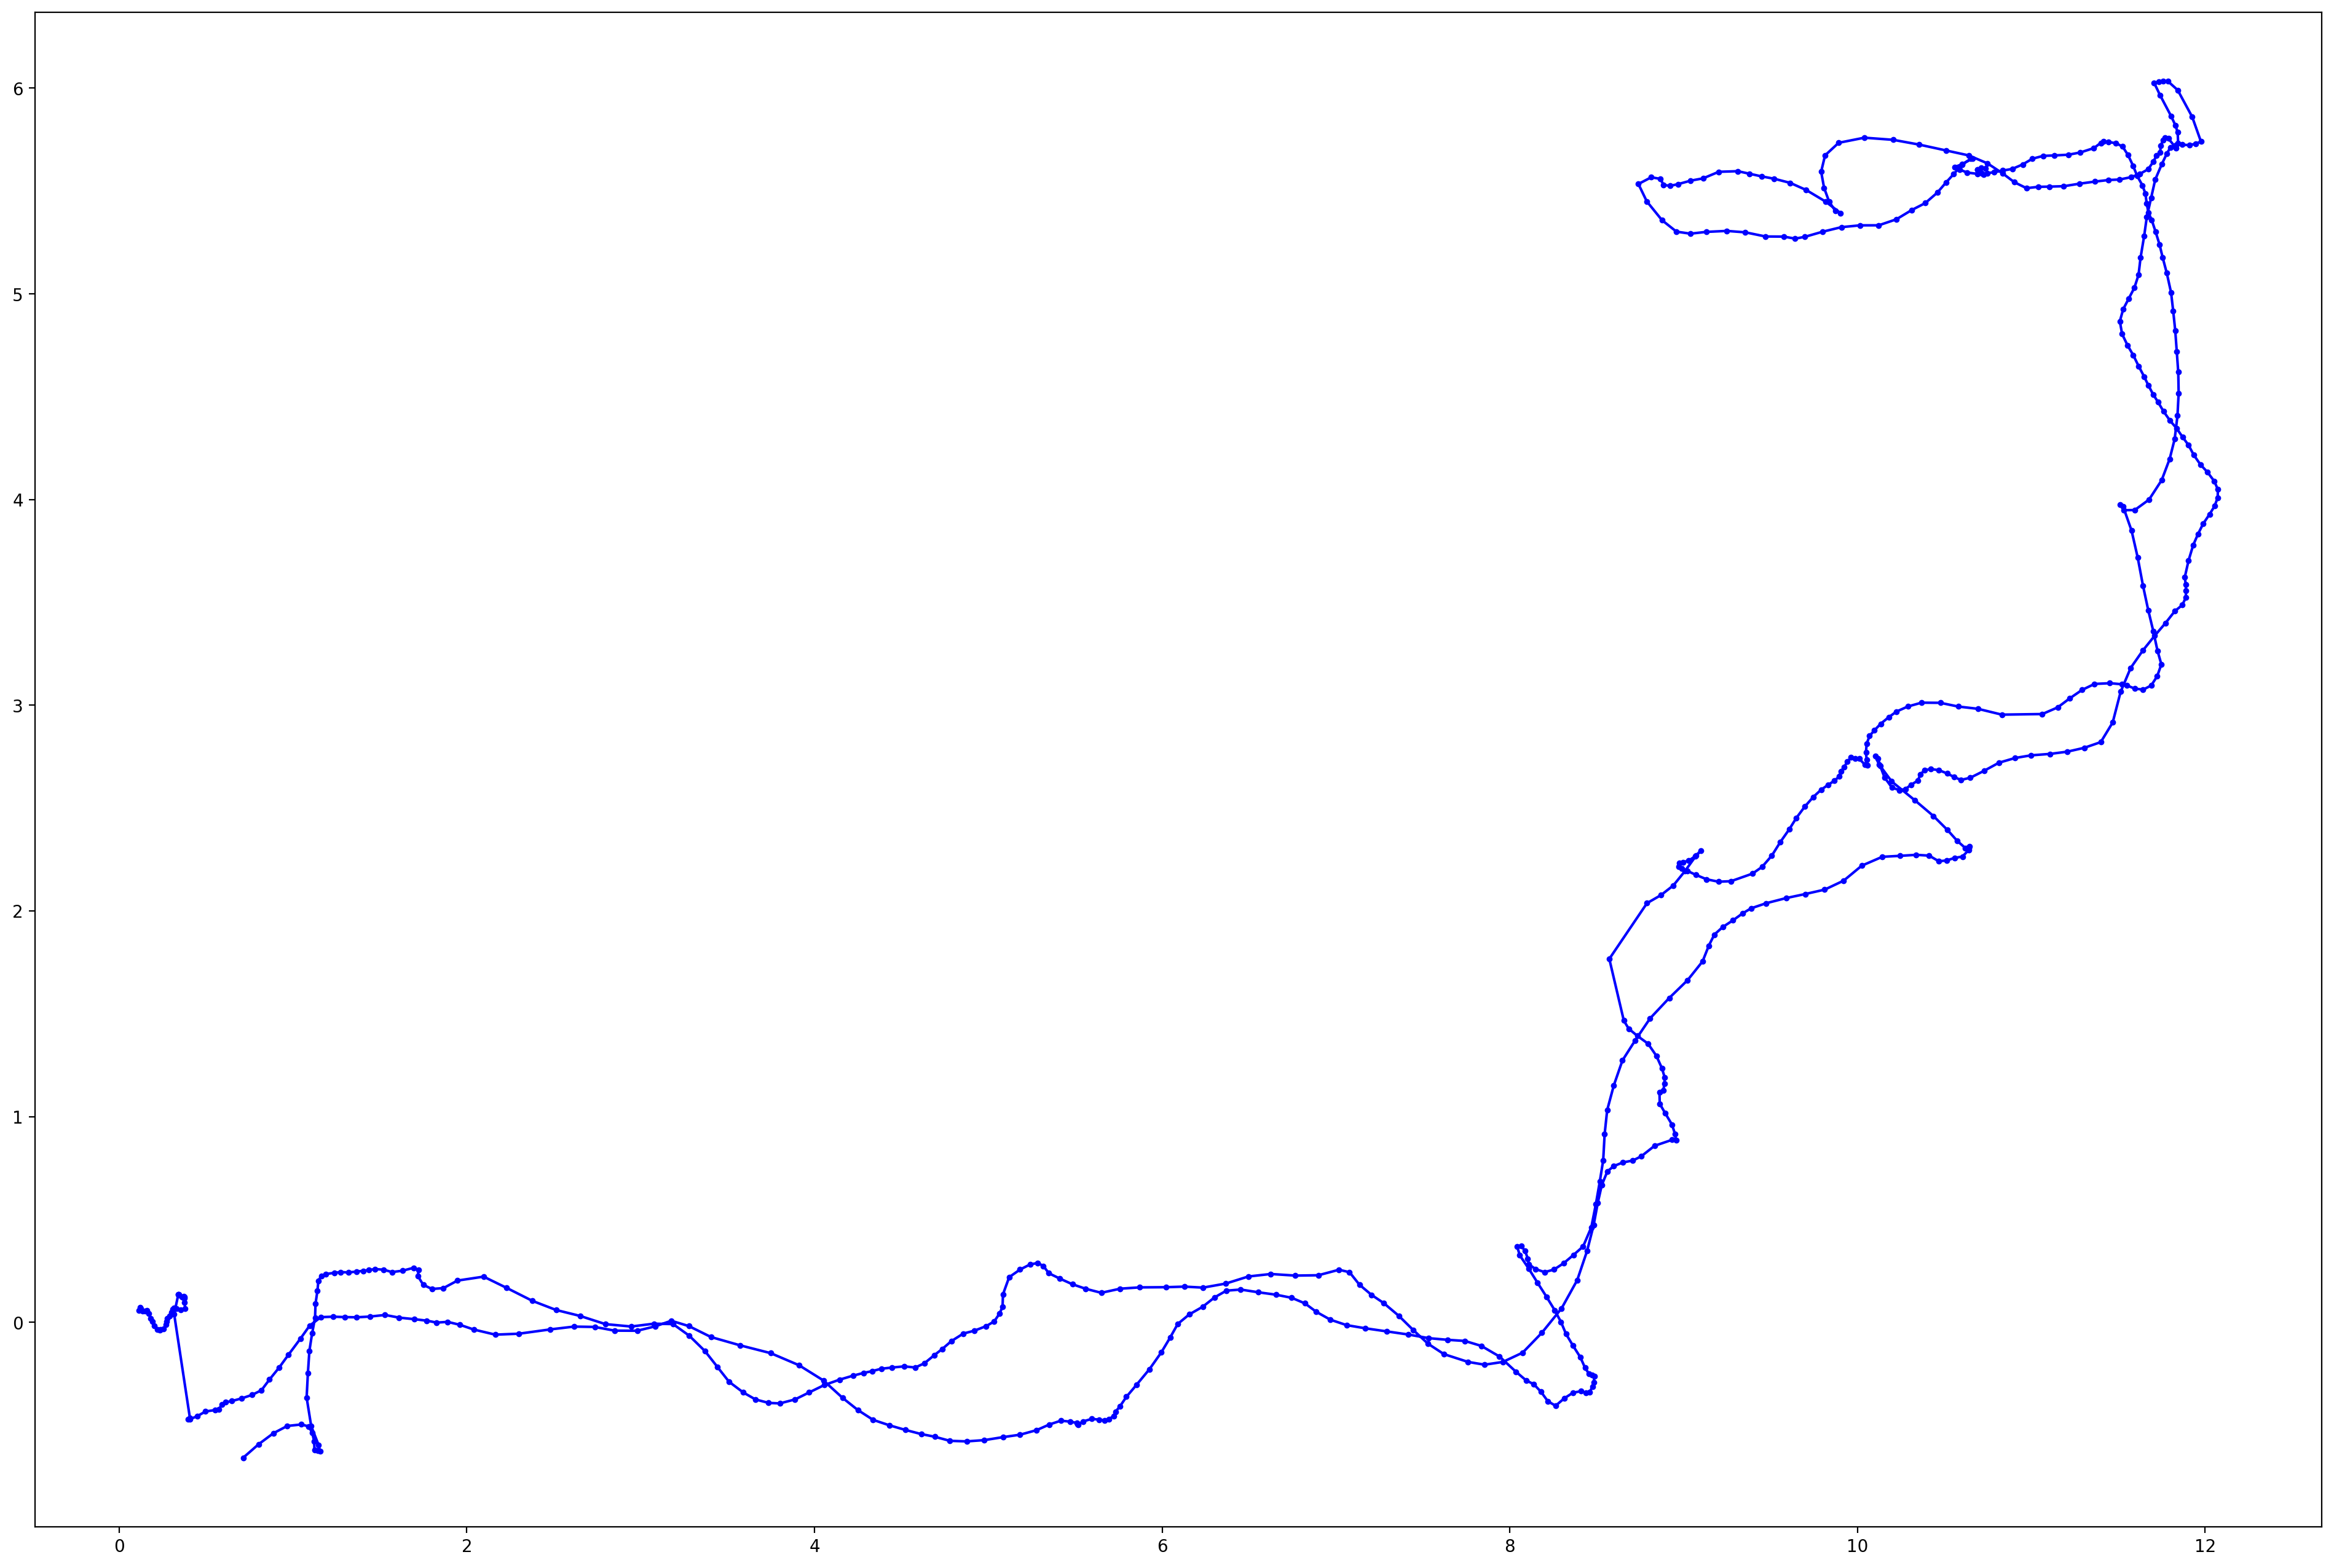

In [48]:
plt.figure(figsize=(24,16), dpi=200)
plt.plot(x[::31], y[::31], '-b.', markersize=5)
plt.show()

## Laser Scan Vs Point Cloud
*ls2pc* - converts ranges to their corresponding x,y coordinates


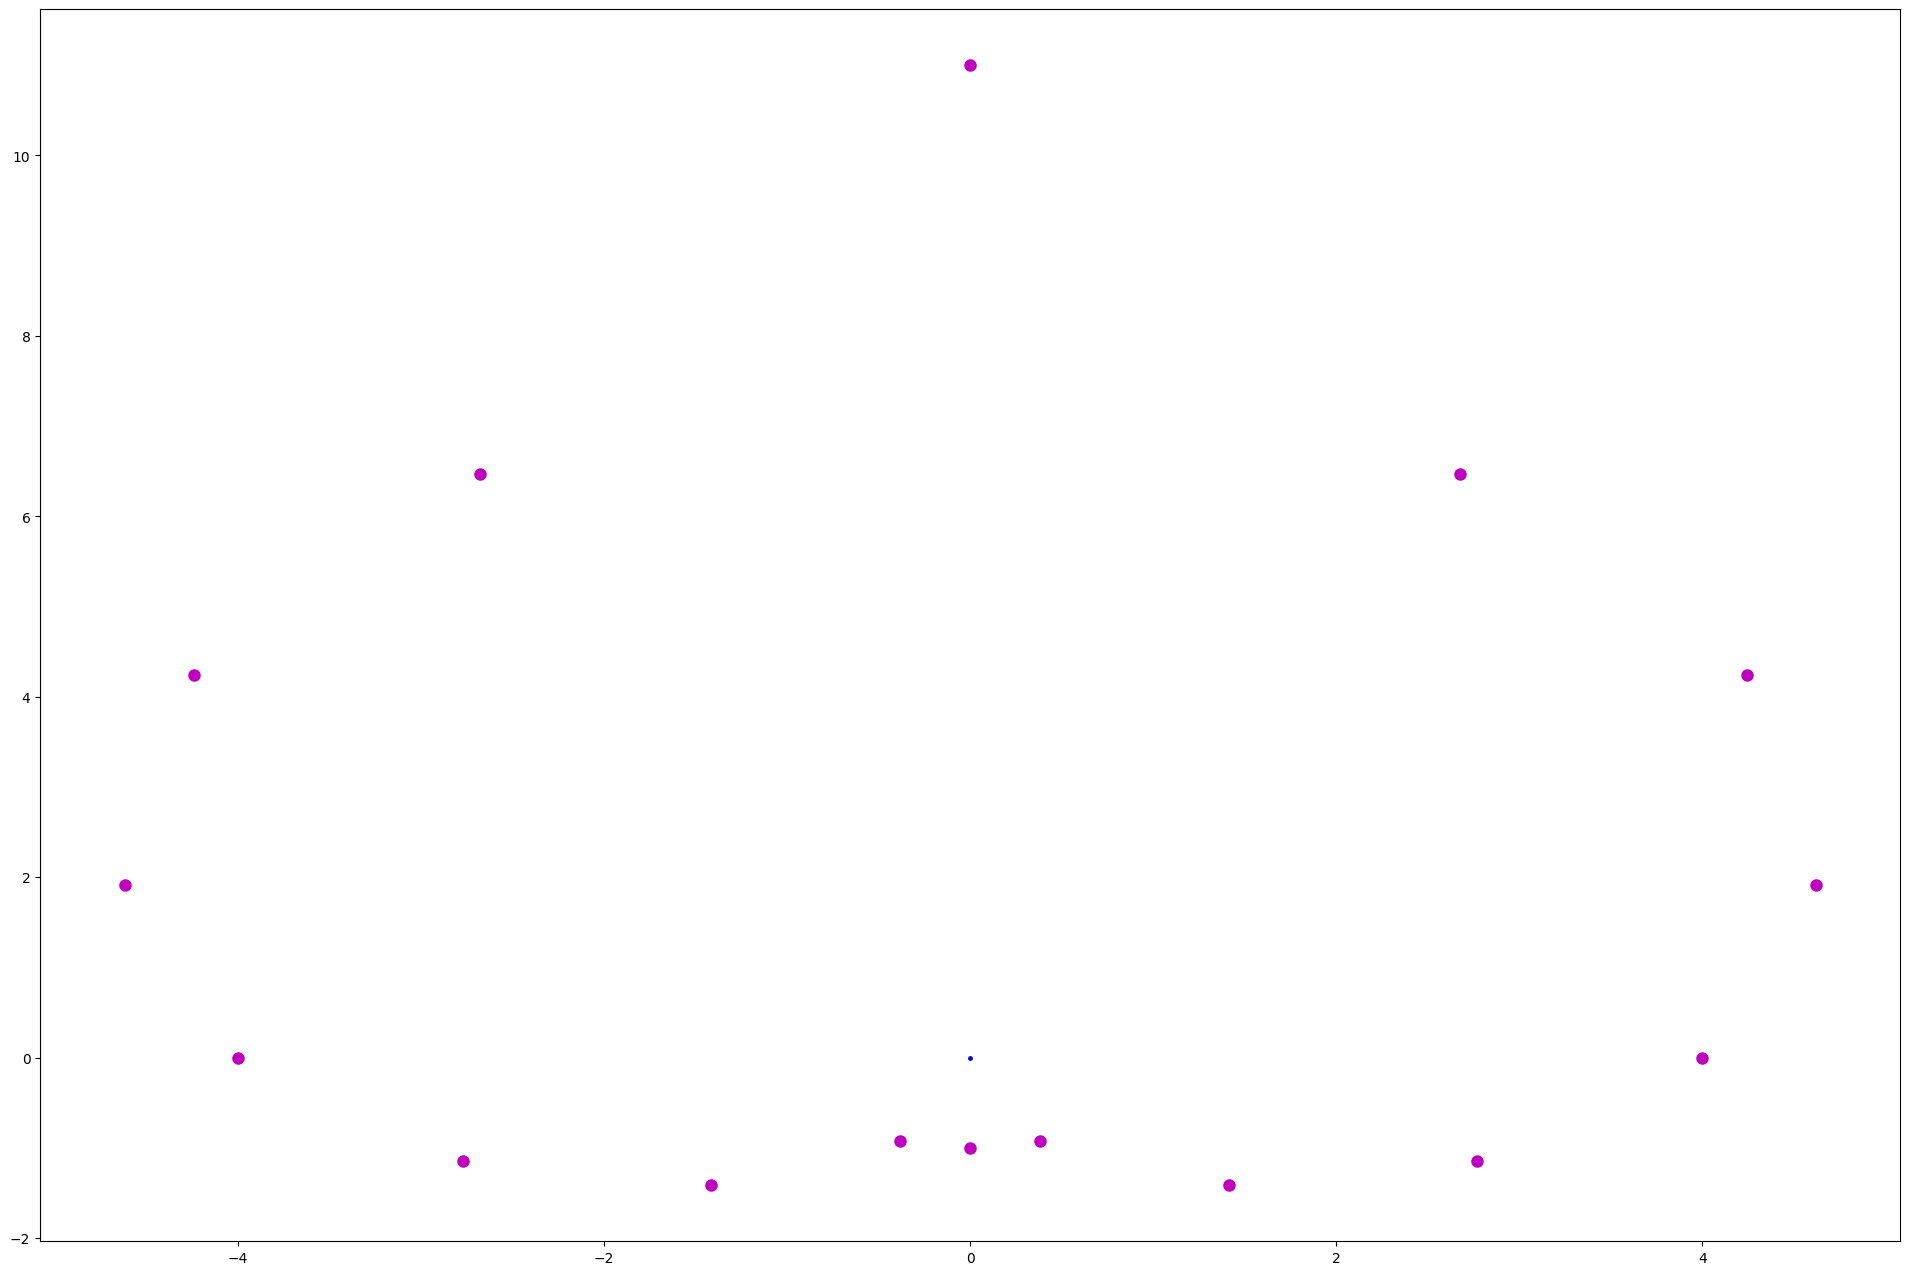

In [49]:
# This is a laser scan (LS) range array:
range_ = np.array([[1,1,2,3,4,5,6,7,11,7,6,5,4,3,2,1]])
# convert the LS to point cloud, using the information about the sensor orientations relative to each other:
x_origin = np.array([0])
y_origin = np.array([0])
yaw = np.array([0])

pc_x_r_, pc_y_r_, valid_inds_bool_, valid_inds_ = ls2pc(x_origin, y_origin, yaw, range_)

# plot the point cloud
plt.figure(figsize=(24,16), dpi=100)
plt.plot(pc_x_r_, pc_y_r_, 'm.', markersize=16)
plt.plot(0, 0, '-b.', markersize=5)
plt.show()

# play around with the other inputs of ls2pc: x_origin, y_origin, yaw.

## Add the laser scanner data


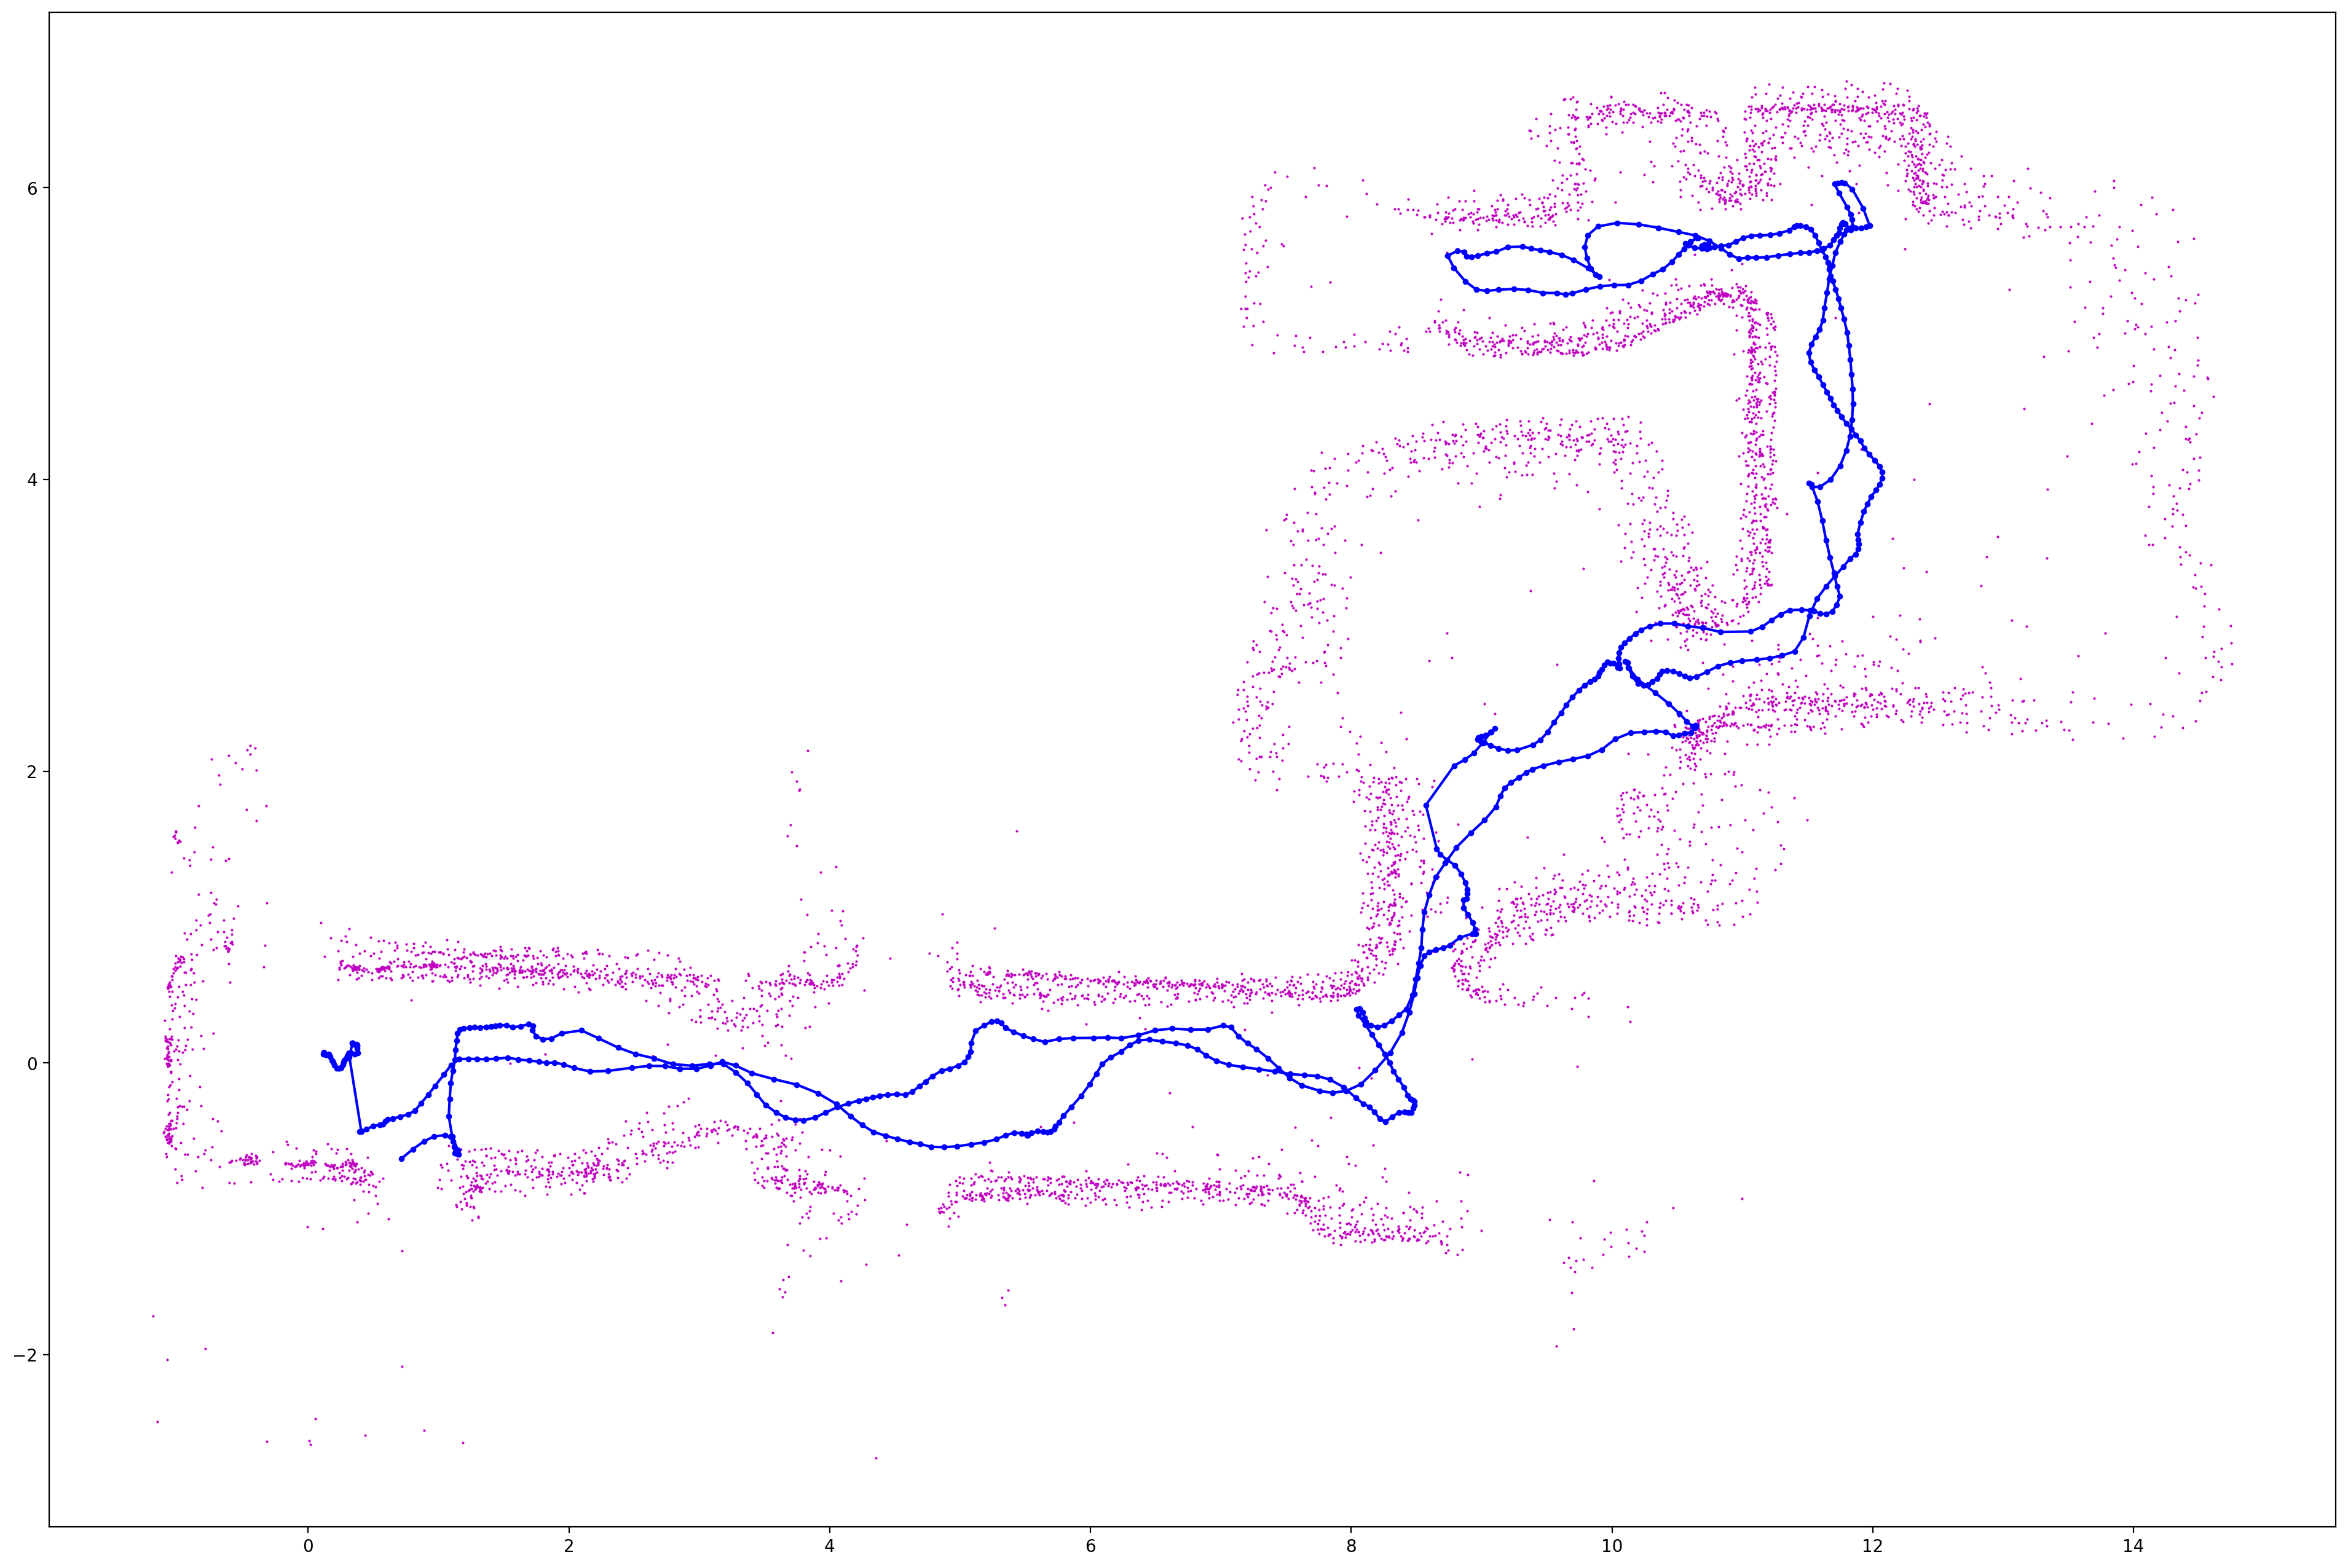

In [50]:
# Convert laser scan (16 ranges) to point cloud (2x16 xy coordinates)
pc_x_r_, pc_y_r_, valid_inds_bool_, valid_inds_ = ls2pc(x, y, t, ranges)
plt.figure(figsize=(24,16), dpi=200)
plt.plot(pc_x_r_[valid_inds_bool_][::31], pc_y_r_[valid_inds_bool_][::31], 'm.', markersize=1)
plt.plot(x[::31], y[::31], '-b.', markersize=5)
plt.show()

**What you see above is the same data ploted in the README.md**

In blue is the odometry - the xy coordinates of spot.

In magenta - the walls\objects picked up by the range sensors.

In [51]:
# convert laser scans to point cloud:
pc_x_r, pc_y_r, valid_inds_bool, valid_inds = ls2pc(x, y, t, ranges)

### Plot location with incrementally changing color:

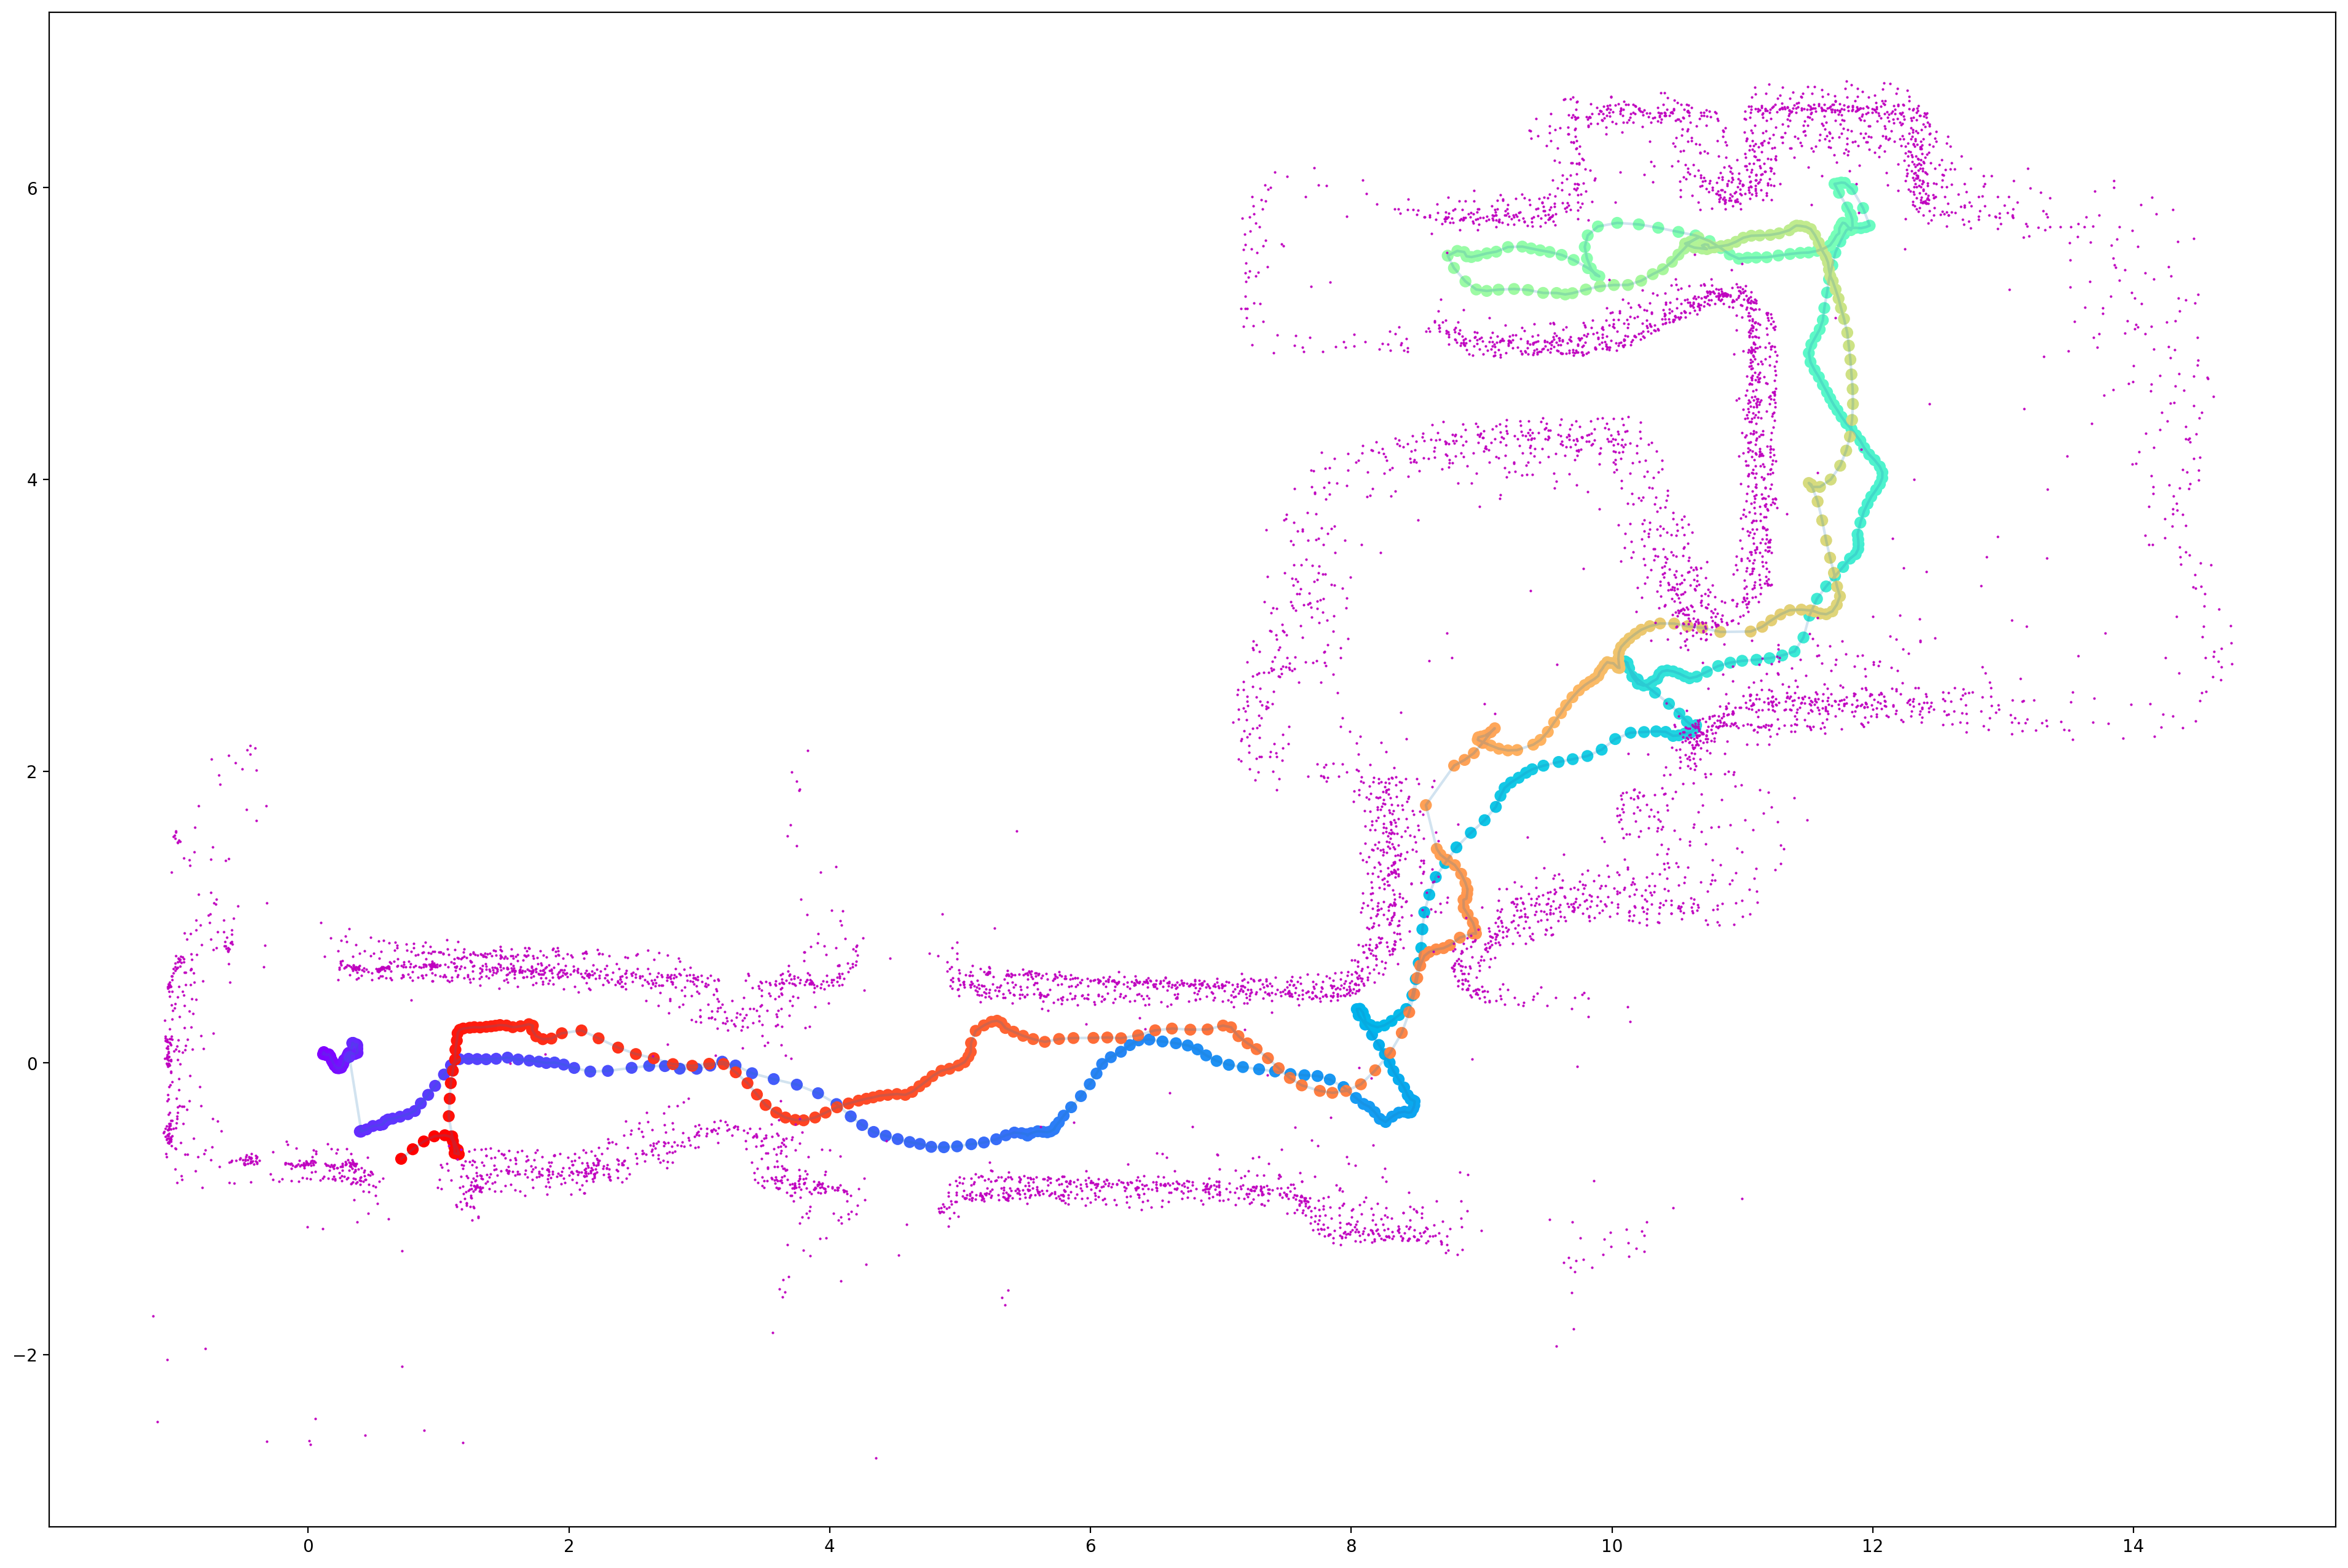

In [52]:
import matplotlib.cm as cm
c = cm.rainbow(np.linspace(0, 1, len(y[::31])))

plt.figure(figsize=(24,16), dpi=200)
plt.plot(pc_x_r_[valid_inds_bool_][::31], pc_y_r_[valid_inds_bool_][::31], 'm.', markersize=1)
plt.plot(x[::31], y[::31], alpha=0.2)
plt.scatter(x[::31], y[::31], color=c)
plt.show()

Note that the color of the location markers changes as a function of time (temporally close measurements closly colored)

### Task #1
1. Add 2 markers colored green and red. The green indicating the starting position and the red indicating the final.
2. Change the color of the odometry marker to visualize what percent of the 16 range measurements are above 2 meters. Use the color gradient 0%-black, 100%-blue.
    
  If $X_{x, y}^i$ is the location of spot at time $t_i$, and $\{r_n^i\}_{n=1}^{16}$ are the range measurements at time $t_i$, then the marker of $X_{x, y}^i$ will be colored as follows:

  $$f(\overline{r}~^i)=f(r_1^i,\ r_2^i,\ ...,\ r_{16}^i)=\sum_{n=1}^{16}\frac{1}{16}(r_n^i>2.0)$$
    
  $$Color(X_{x, y}^i)=\{R^i, G^i, B^i\} = \{0,\ 0,\ 255\cdot f(r_1^i,\ r_2^i,\ ...,\ r_{16}^i)\}$$

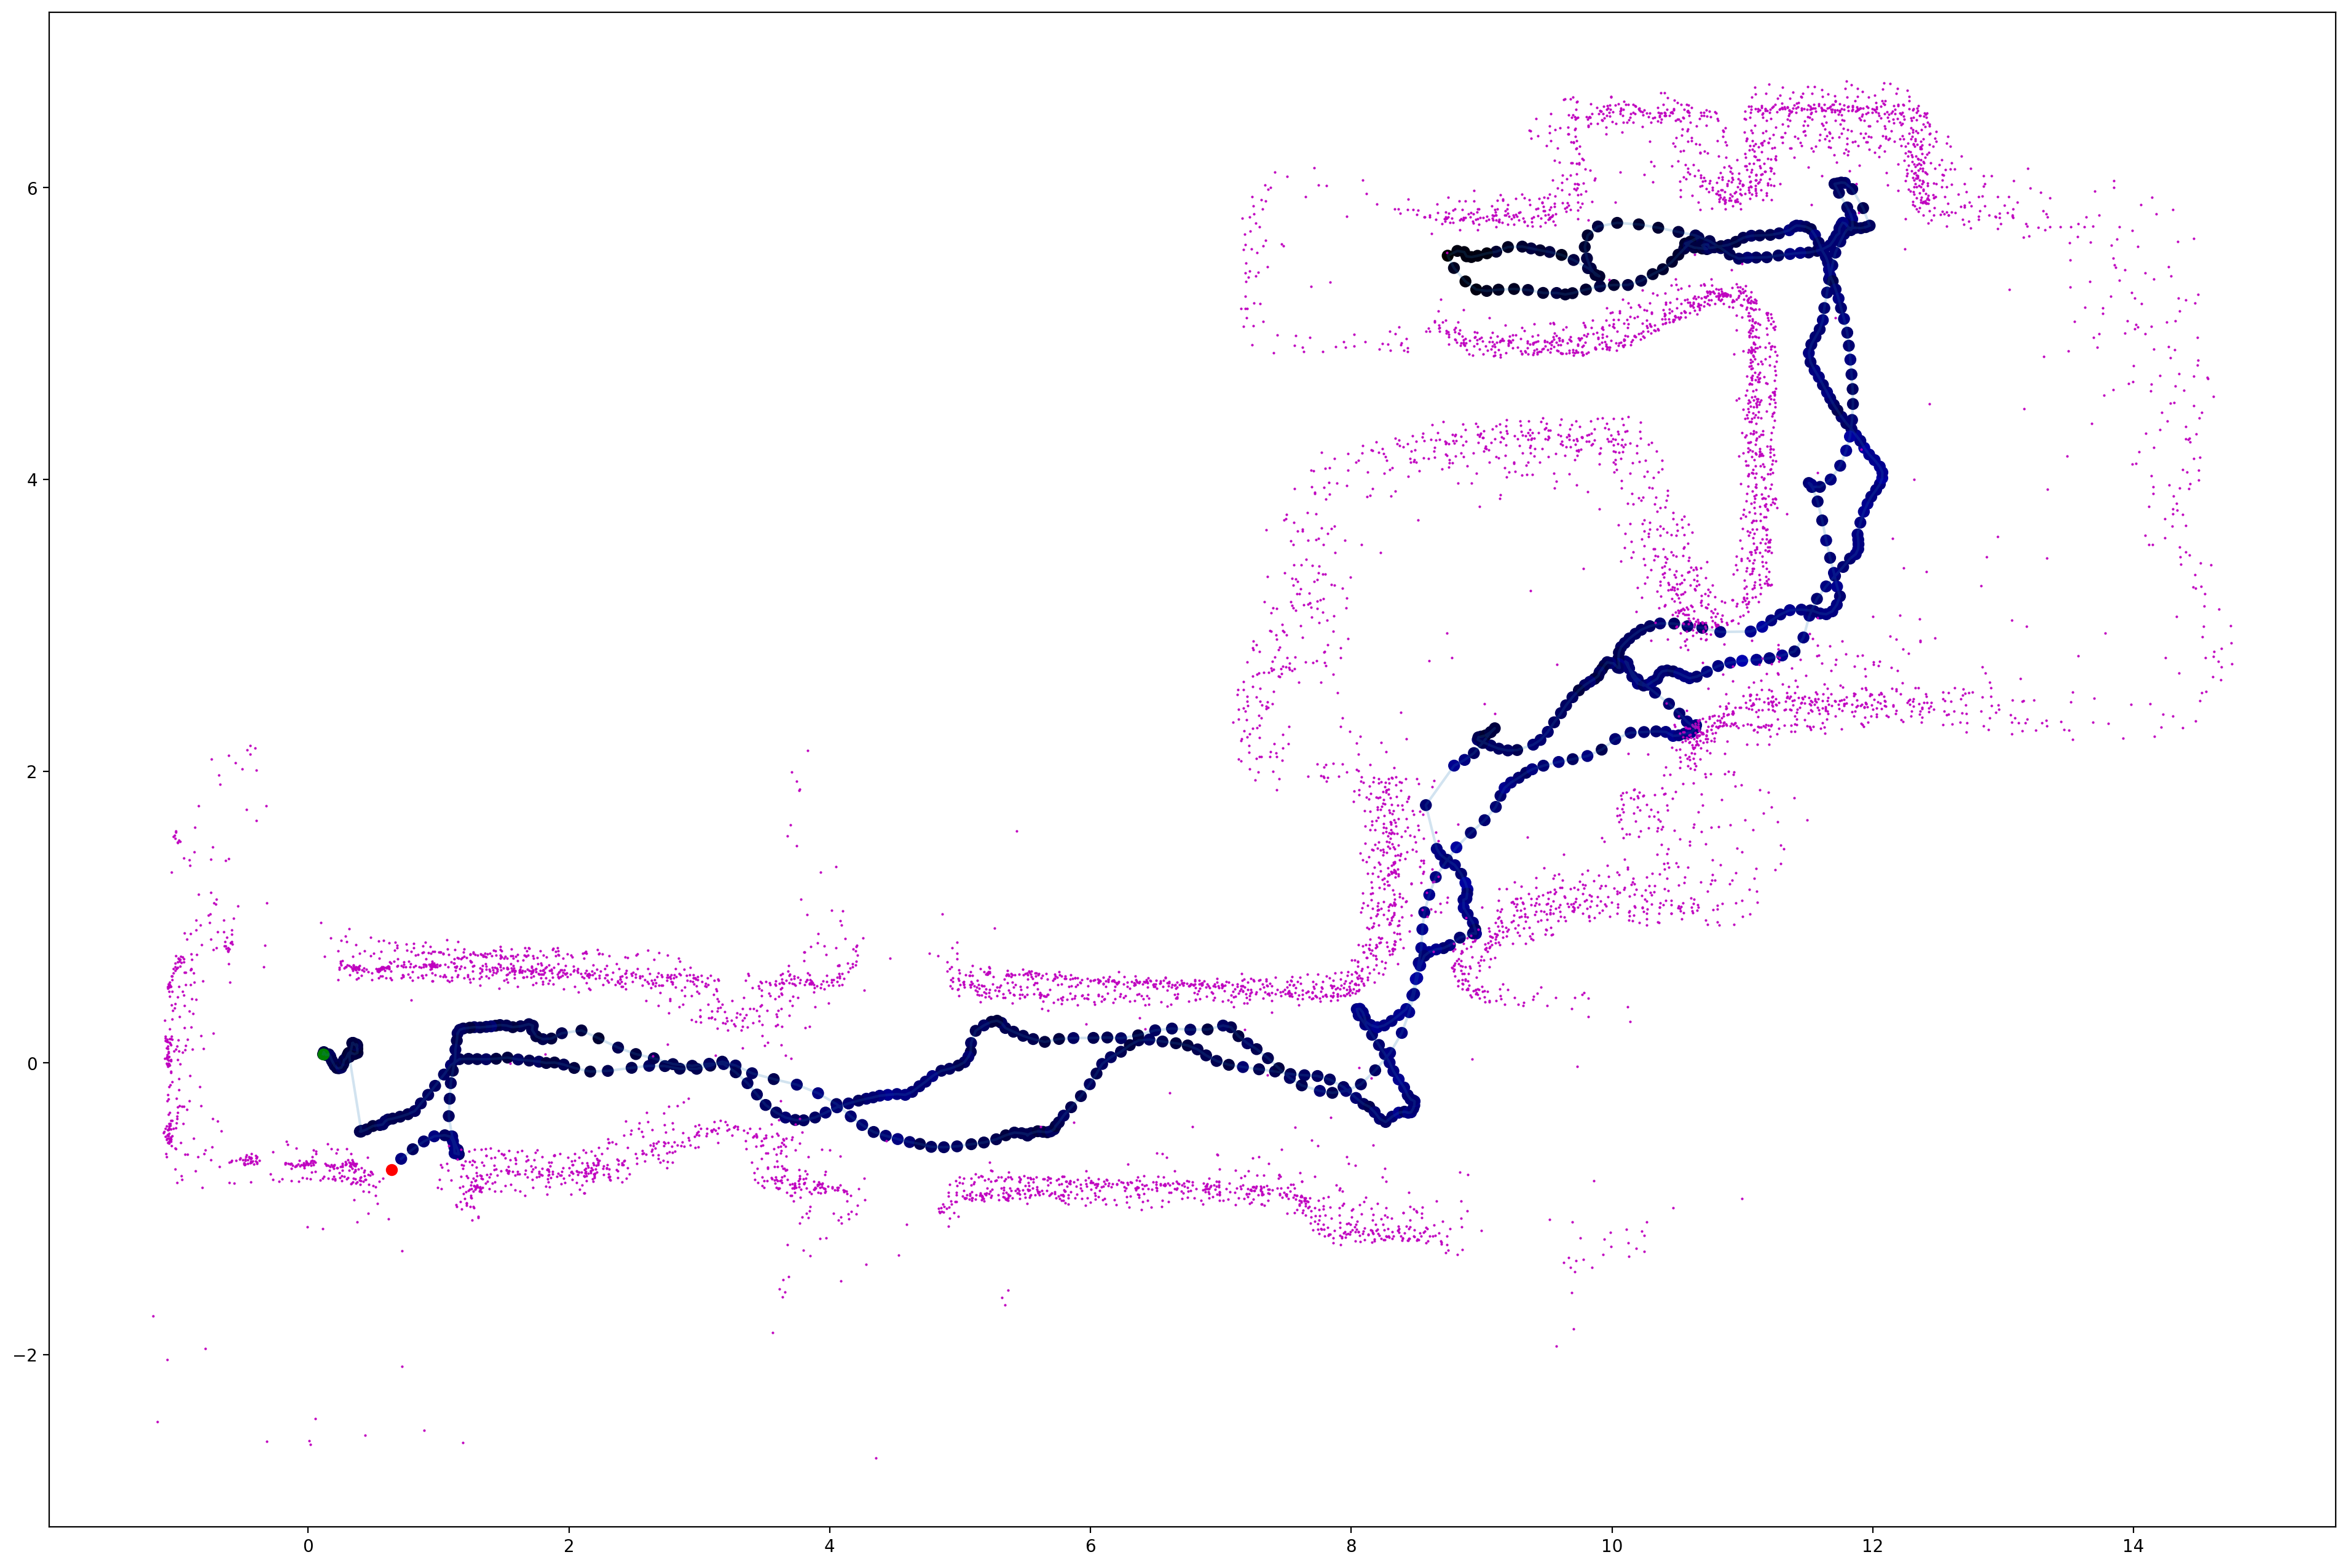

In [53]:
import numpy as np
import matplotlib.pyplot as plt

## New Markers ##
start = (x[0],y[0])
end = (x[-1],y[-1])

## Colored MR18 ##
# 1. Calculate the fraction of ranges > 2.0m for every timestamp
# (ranges > 2.0) creates a boolean mask, .mean(axis=1) averages it per row
fractions = (ranges > 2.0).mean(axis=1)

# 2. Create the RGB colors for ALL points first
# Initialize (N, 3) array with zeros (Black)
colors_all = np.zeros((len(x), 3))
# Set Blue channel (index 2) to the fraction (0.0 to 1.0)
colors_all[:, 2] = fractions

# 3. Subsample the colors to match the plot slicing [::31]
c = colors_all[::31]

## Final Plot ##
plt.figure(figsize=(24,16), dpi=200)
# Plot Point Cloud (background)
plt.plot(pc_x_r_[valid_inds_bool_][::31], pc_y_r_[valid_inds_bool_][::31], 'm.', markersize=1)
# Plot Trajectory Line
plt.plot(x[::31], y[::31], alpha=0.2)
# Plot Trajectory Points with Black-Blue Gradient
plt.scatter(x[::31], y[::31], color=c) # Added s=20 to make points visible
# Plot Start/End
plt.scatter(start[0], start[1], color="green") # Added size and zorder
plt.scatter(end[0], end[1], color="red")

plt.show()

### Task #2:
In your own words write a short explanation about what this feature ($f$) represents. If spot is in a location that is blue rather than black, what does this say about the surrounding?

two possible interpretations:
1. clearance/safety score - blue spots indicate locations where the robot is at higher risk of collisions, black spots are where the robot's space is mostly free.
to fine-tune this measurement we should set the cutoff threshold close to the robot's dimensions, plus some expansion for safety margins.
2. reliability measurement - blue spots indicate "good reading" of all measurements, black spots indicate invalid, or unreliable measurements.
to fine-tune this we should set the cutoff threshold closer to the sensor's max range reading (in our case, closer to 4000).

### Task #3
What would you change in the above feature function $f$ so that it would be smoother and less discrete?

$|f^*(\overline{r}~^i)-f^*(\overline{r}~^{i-1})|~~<~~|f(\overline{r}~^i)-f(\overline{r}~^{i-1})|$

Add a plot with your suggestion and add a measure of smoothness that quanitfies how much smoother is your improved $f^*$ relative to $f$.

**Hint:** take a look at the **get_sigmoid** function in `utils.py`

Roughness Score (Original): 280.9375
Roughness Score (Smoothed): 258.0815
Improvement Factor: 1.09x smoother


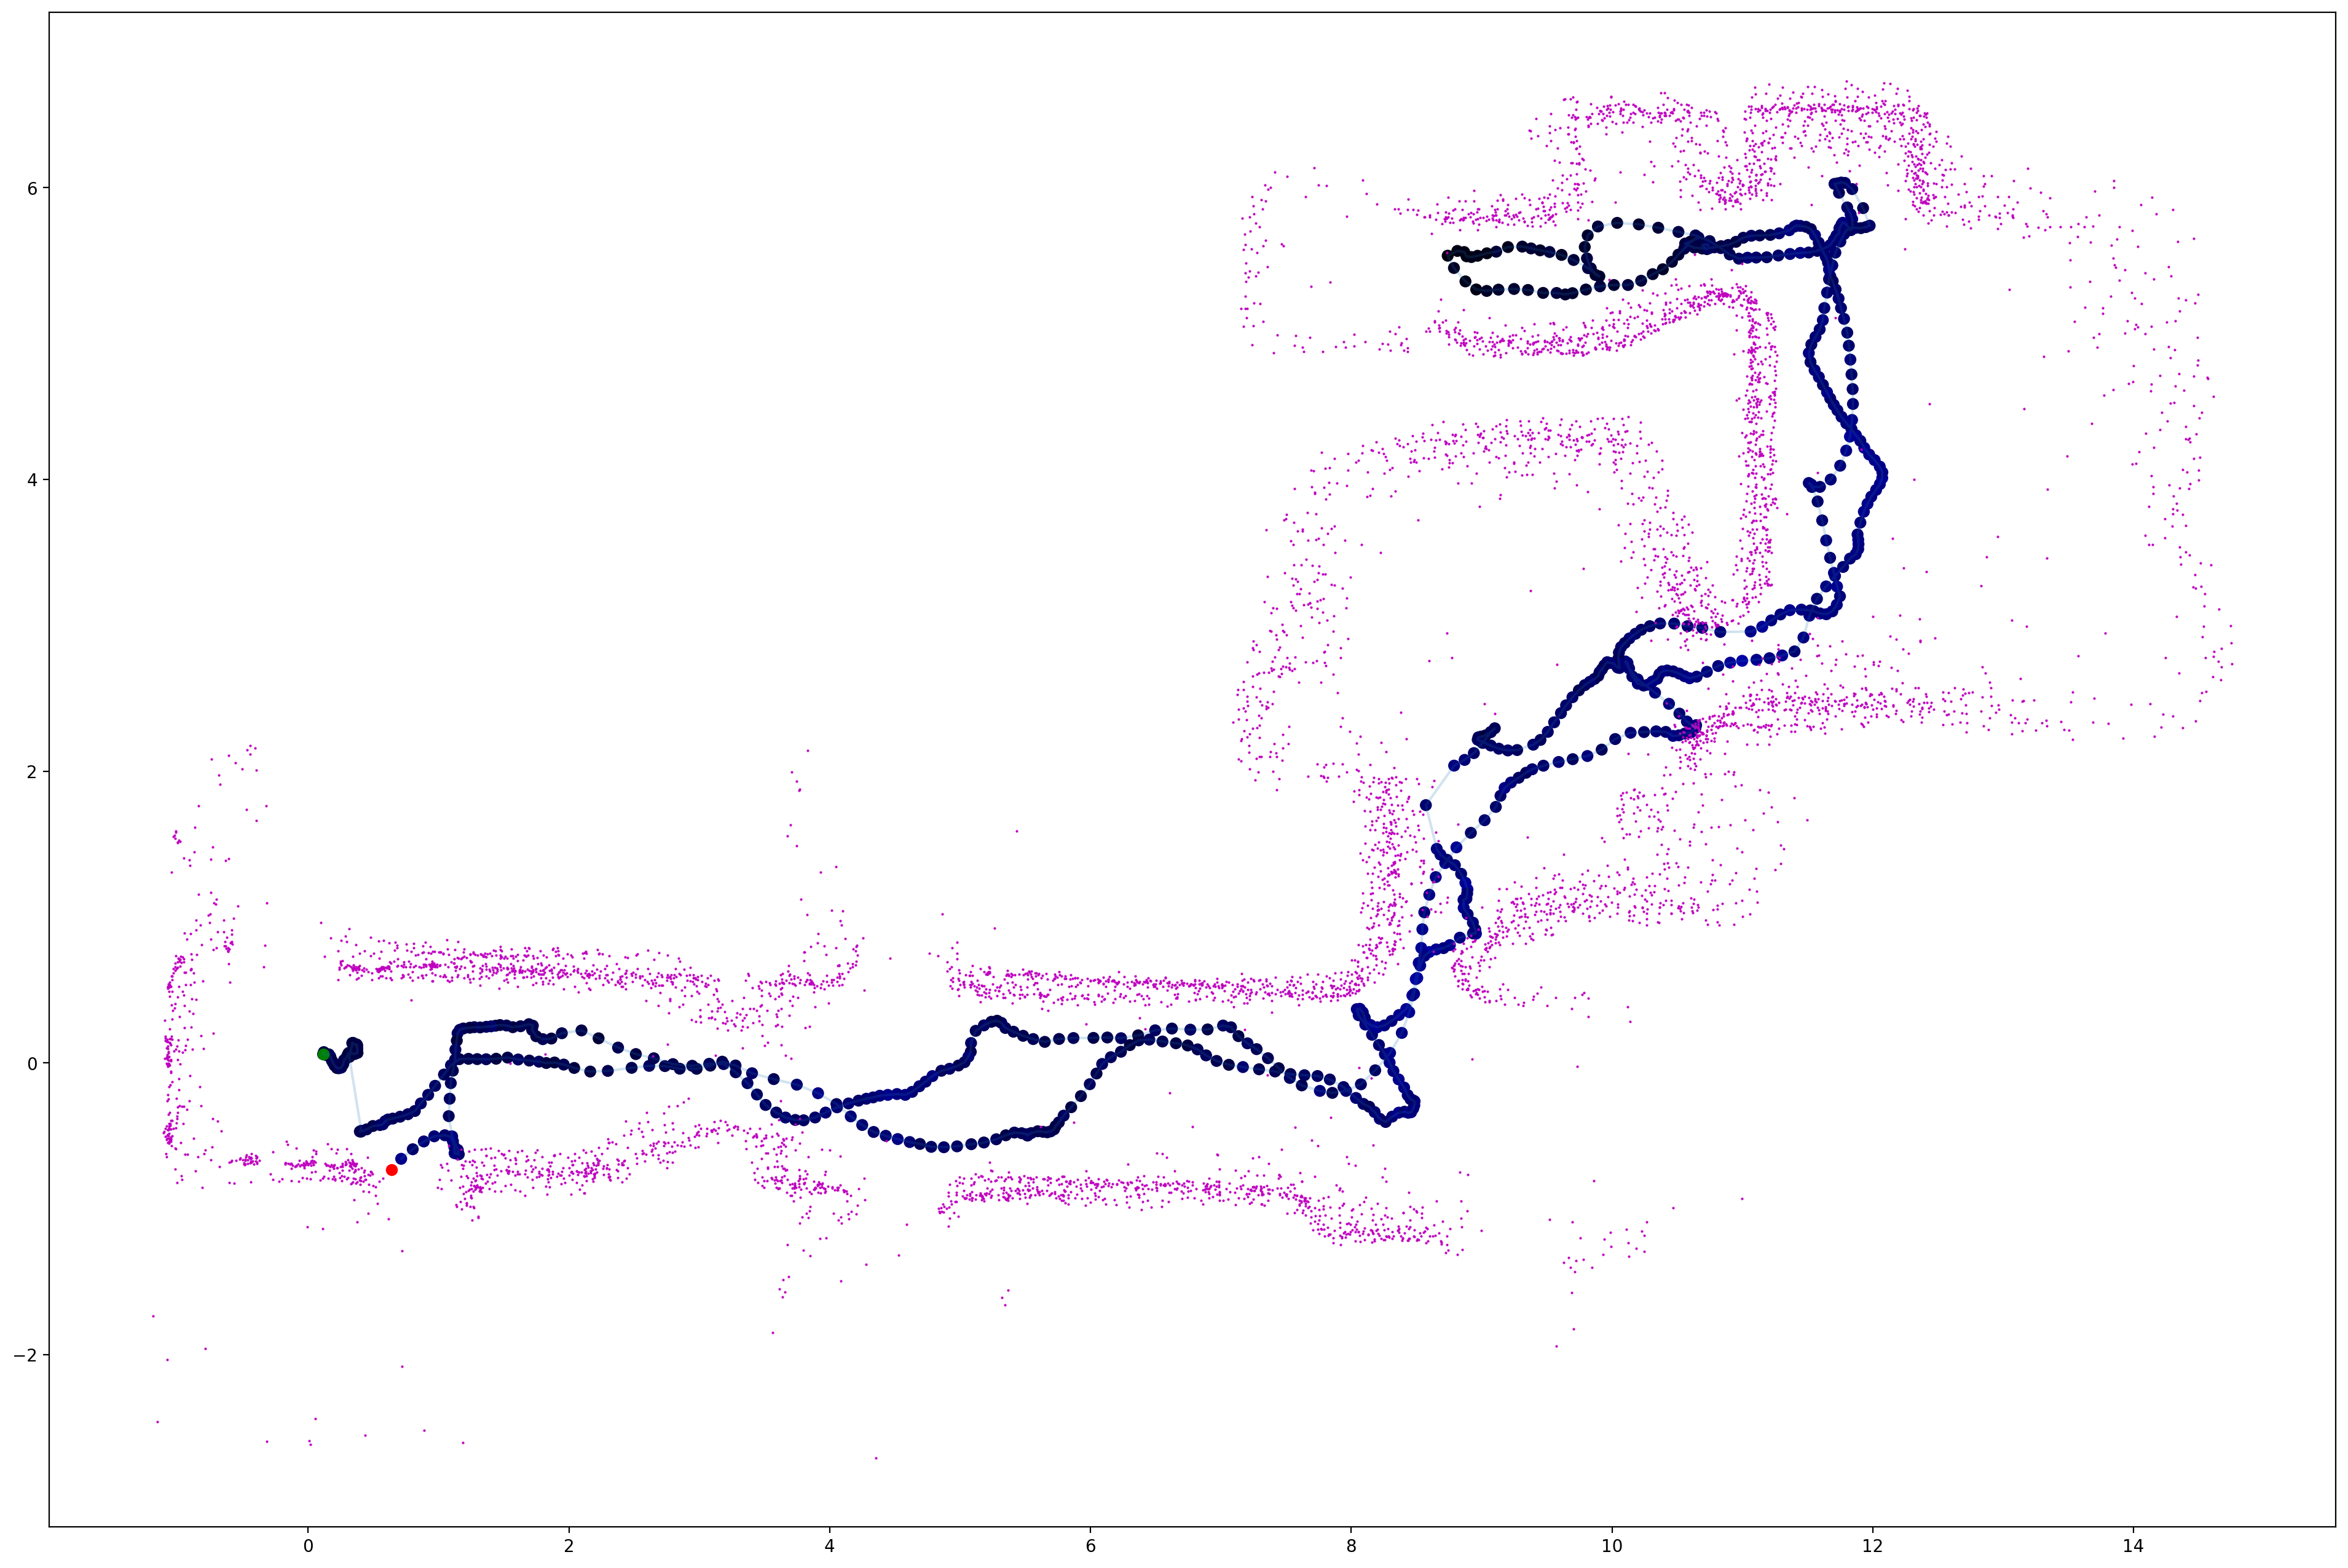

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from utils import get_sigmoid

# --- 1. Define the Smooth Function ---
# We use get_sigmoid to create a curve that is "mostly 1" (0.95) 
# when we are 0.5m past the threshold.
# You can tweak percent_loc (width of transition) to make it smoother/sharper.
smooth_step = get_sigmoid(percent_loc=0.5, percent_val=0.95)

# --- 2. Calculate f (Original) and f* (Smoothed) ---

# f: The original discrete version (Hard Step)
# Logic: 1 if > 2.0, else 0
f_original = (ranges > 2.0).mean(axis=1)

# f*: The new smooth version (Soft Sigmoid)
# Logic: Sigmoid centered at 2.0. 
# We feed (ranges - 2.0) so that 2.0 becomes 0 (the center of sigmoid)
f_smooth = smooth_step(ranges - 2.0).mean(axis=1)

# --- 3. Quantify Smoothness ---
# We measure "roughness" as the sum of absolute changes between consecutive steps.
# Lower score = Smoother.
diff_original = np.abs(np.diff(f_original))
diff_smooth = np.abs(np.diff(f_smooth))

score_original = np.sum(diff_original)
score_smooth = np.sum(diff_smooth)

print(f"Roughness Score (Original): {score_original:.4f}")
print(f"Roughness Score (Smoothed): {score_smooth:.4f}")
print(f"Improvement Factor: {score_original / score_smooth:.2f}x smoother")

# --- 4. Plot Comparison ---
colors_all = np.zeros((len(x), 3))
colors_all[:, 2] = f_smooth
c = colors_all[::31]

plt.figure(figsize=(24,16), dpi=200)
plt.plot(pc_x_r_[valid_inds_bool_][::31], pc_y_r_[valid_inds_bool_][::31], 'm.', markersize=1)
plt.plot(x[::31], y[::31], alpha=0.2)
plt.scatter(x[::31], y[::31], color=c) 
plt.scatter(start[0], start[1], color="green")
plt.scatter(end[0], end[1], color="red")

plt.show()

### Summary:

In this preliminary notebook we learned:
1. What the data looks like (laser scan and odometry)
2. We learned how to display the data with matplotlib
3. Finally, in the tasks, we built a single feature that indicates a type of surrounding based on a laser scan.

Next, we will add more feature functions. These will be the bassis for bulding the required classifier mentioned in the *README.md*.

In [71]:
try:
    from data_exercise.utils import get_features_from_ranges
except ModuleNotFoundError as e:
    from utils import get_features_from_ranges

featureMat = get_features_from_ranges(ranges)

print('ranges shape = {}'.format(ranges.shape))
print('featureMat shape = {}'.format(featureMat.shape))


ranges shape = (20023, 16)
featureMat shape = (20023, 12)


## Lets use these features to build a classifier:


The BD engineers want to create a classifier. A classifier that takes as inputs 16 range measurements and decides which of the 3 classes these 16 measurements belong to. The engineers do not care what the meaning of these classes are, as long as the following criterion's are met:

1. Close laser scan readings are classified to the same class with a high probability.

   **Note:** This also means that cyclically shifting a measurement should not influence the classifier.

   For example:
   $$
   \begin{aligned}
   Class(r^0_i,r^1_i,..., r^{15}_i)==Class(r^1_i,..., r^{15}_i,r^0_i)
   \end{aligned}
   $$

2. The occurrences of each class should distribute as even as possible ($1/3, 1/3, 1/3$) over a recording. 

3. The engineers do not want to manually label the data.



In [111]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca_2comp = PCA(n_components=7)
kmeans_pca = KMeans(n_clusters=3, init='k-means++', random_state=42)



#### Task 4: Implement the calculation of `labeled_ranges`:

Read about these 3 functions (KMeans, StandardScaler and PCA).

Use `scaler.fit_transform`, `pca_2comp.fit_transform` and `kmeans_pca.fit_predict` to build a classifier.

In [112]:
# Enter Your  code here 
# Hint: this can be implemented in 3 function calls
#       e.g. labeled_ranges = f1(f2(f3(featureMat)))

labeled_ranges = kmeans_pca.fit_predict(pca_2comp.fit_transform(scaler.fit_transform(ranges)))

# What is the reason for all these stages?
# normalize and flatten the data into something more managable.

In [113]:
print(f'shape labeled_ranges = {labeled_ranges.shape}')
print(f'labeled_ranges[:6]={labeled_ranges[:12]}')

shape labeled_ranges = (20023,)
labeled_ranges[:6]=[0 0 0 0 0 0 0 0 0 0 0 0]


### Plot results
note: should look the same as README.md

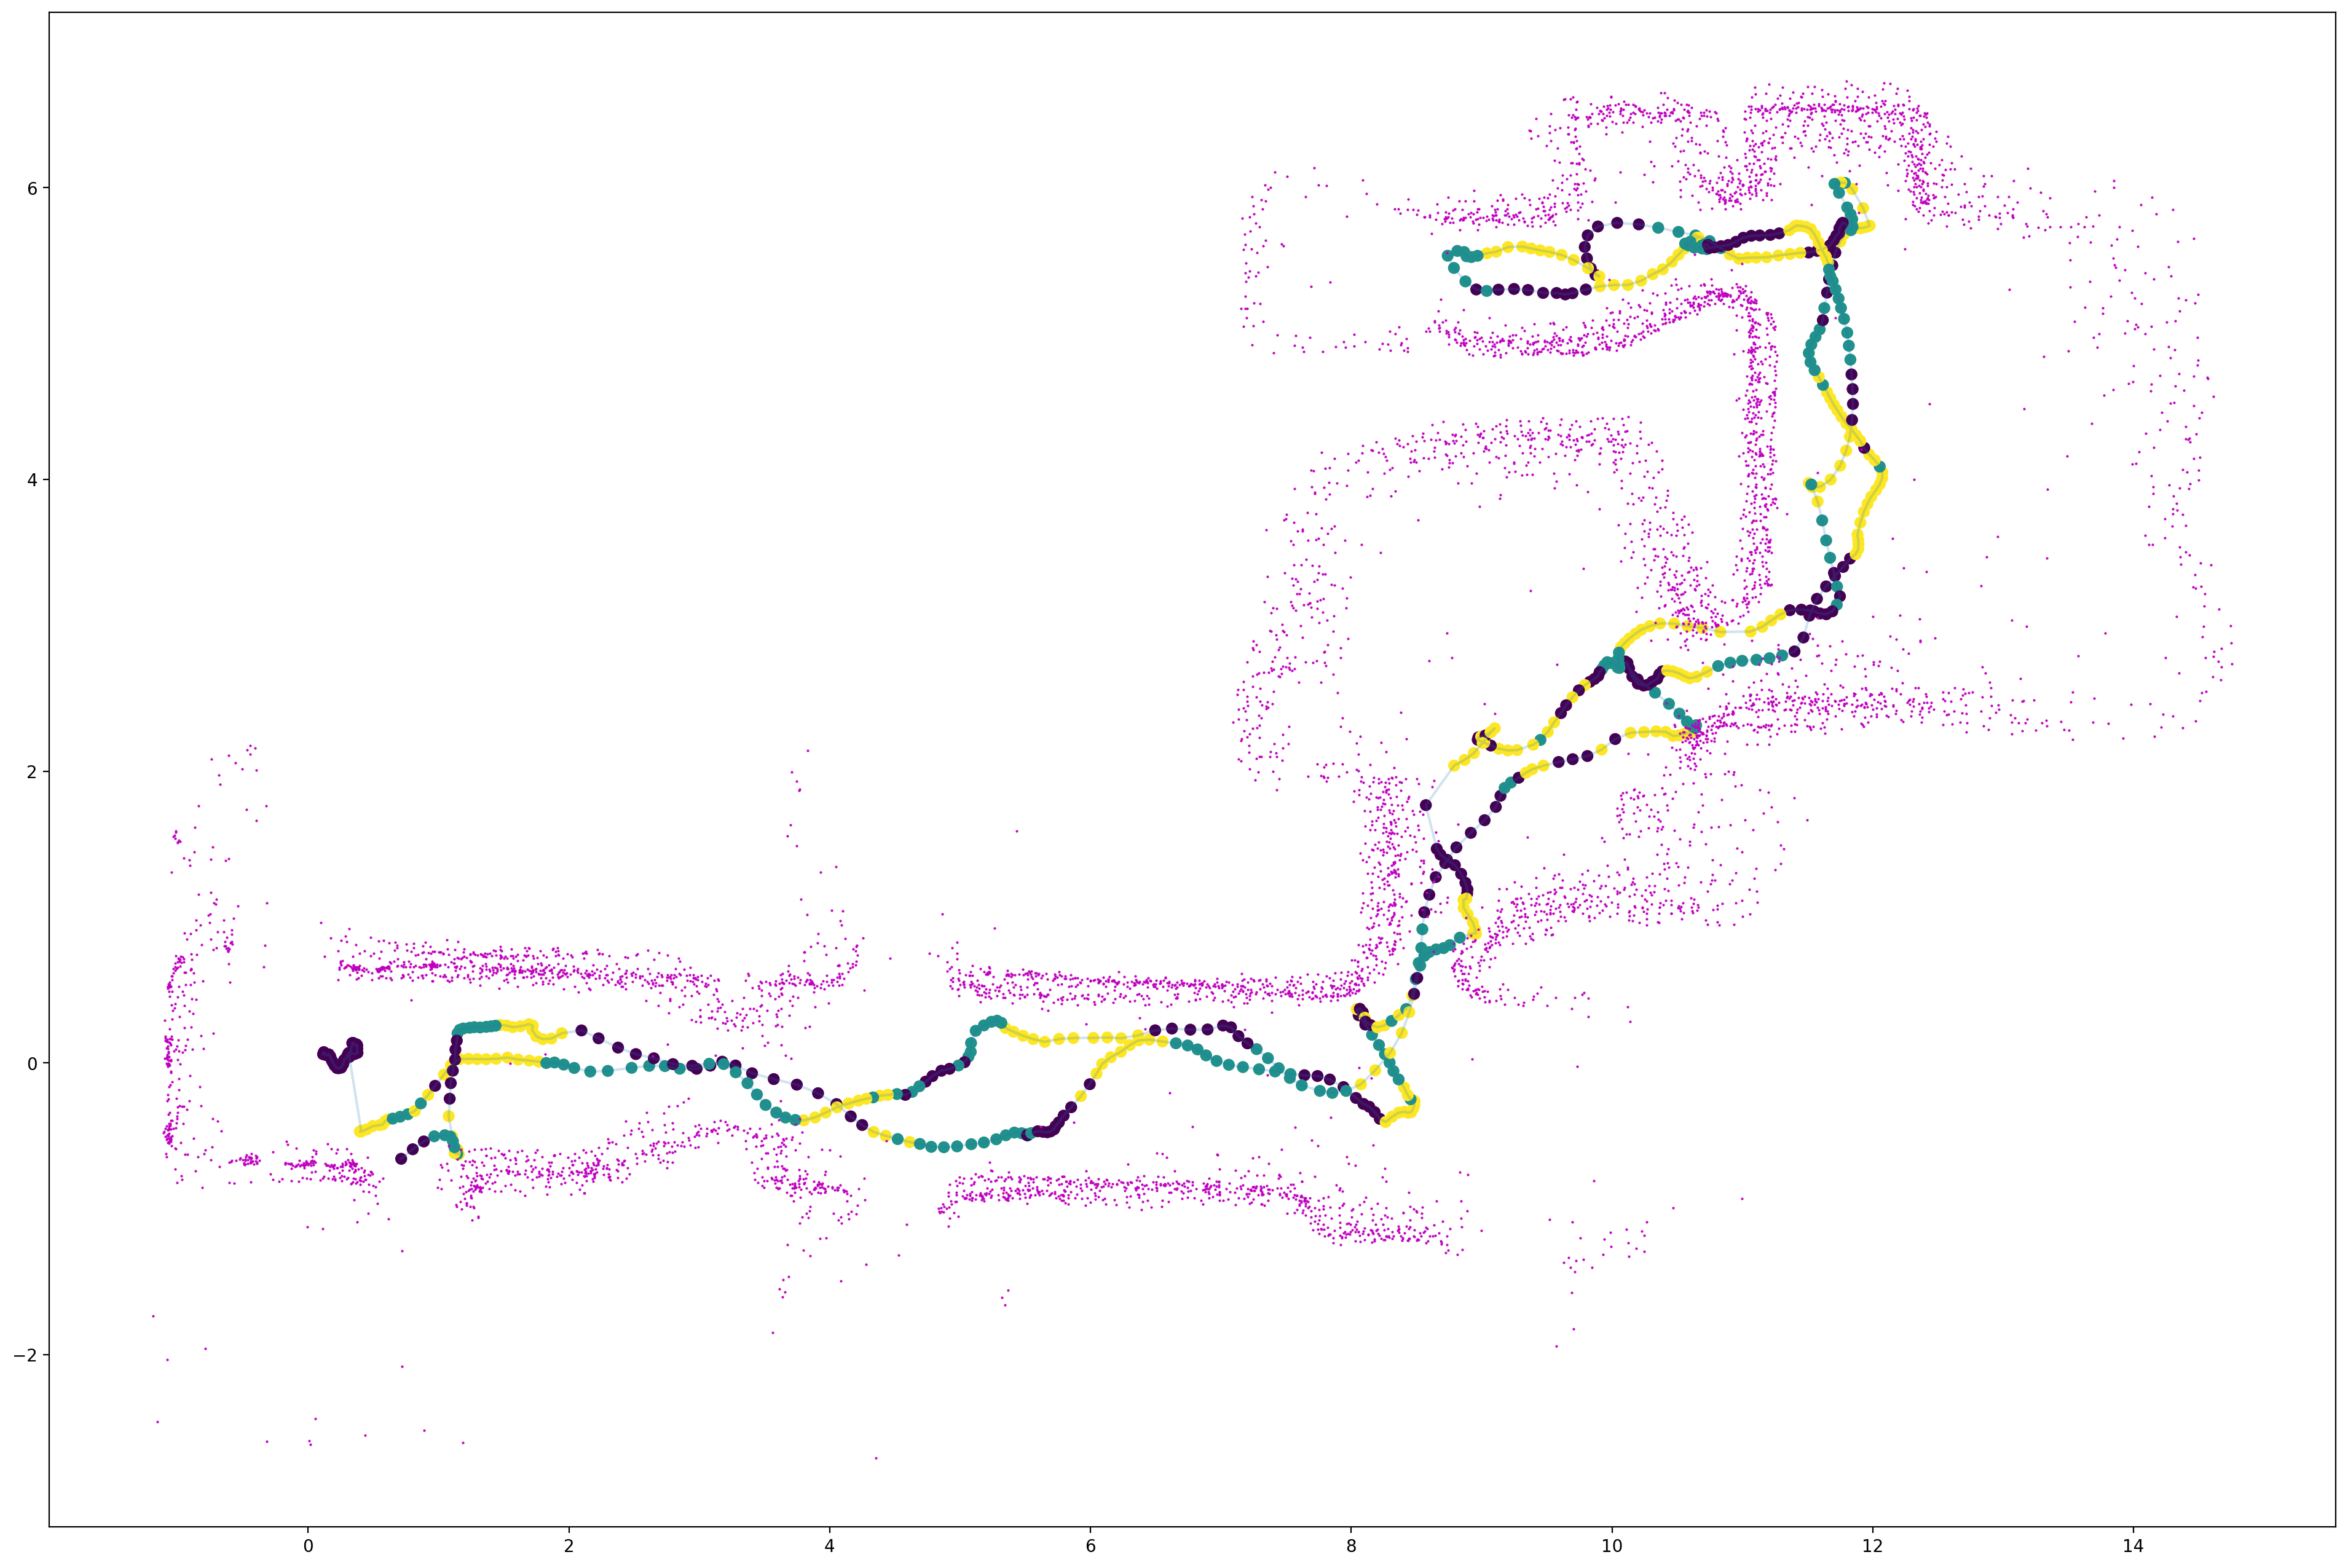

In [114]:
plt.figure(figsize=(24,16), dpi=200)
plt.plot(pc_x_r[valid_inds_bool][::31], pc_y_r[valid_inds_bool][::31], 'm.', markersize=1)
plt.plot(x[::31], y[::31], alpha=0.2)
plt.scatter(x[::31], y[::31], c=labeled_ranges[::31])
plt.show()

### (1) Check if close points are similarly classified:

In [115]:
# Convert to arrays:
X = np.vstack((x, y)).T
Y = labeled_ranges
Y = np.expand_dims(Y, axis=1)

# Suggest a metric:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X, Y)

# Enter code here
Y_pred = knn_model.predict(X)
# implement mismatch error
err = np.round(Y_pred)!=Y
err = np.sum(err)/len(labeled_ranges)
print('Probability error of predicting class based on neighbours = {}'.format(err))


Probability error of predicting class based on neighbours = 0.04729561004844429


### (2) Check uniformness of class distribution:

In [116]:
L = len(labeled_ranges)
p = []
for i in np.unique(labeled_ranges):
    p.append(np.sum(labeled_ranges==i)/L)

print('P({})={}'.format([0,1,2], [np.round(p_,2)  for p_ in p]))

from scipy.spatial.distance import jensenshannon
p_uniform = [1/3, 1/3, 1/3]
d = jensenshannon(p_uniform, p)
print('\njensenshannon distance from uniform distribution = {}'.format(d))

P([0, 1, 2])=[0.33, 0.3, 0.37]

jensenshannon distance from uniform distribution = 0.032639559138315066


In [127]:
## Simple Parameter Tuning ##
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca_2comp = PCA(n_components=5) ## tuned from 7 to 5, got better distribution and error
kmeans_pca = KMeans(n_clusters=3, init='k-means++', random_state=42)
labeled_ranges = kmeans_pca.fit_predict(pca_2comp.fit_transform(scaler.fit_transform(ranges)))
# plt.figure(figsize=(24,16), dpi=200)
# plt.plot(pc_x_r[valid_inds_bool][::31], pc_y_r[valid_inds_bool][::31], 'm.', markersize=1)
# plt.plot(x[::31], y[::31], alpha=0.2)
# plt.scatter(x[::31], y[::31], c=labeled_ranges[::31])
# plt.show()

# Convert to arrays:
X = np.vstack((x, y)).T
Y = labeled_ranges
Y = np.expand_dims(Y, axis=1)

# Suggest a metric:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X, Y)

# Enter code here
Y_pred = knn_model.predict(X)
# implement mismatch error
err_tuned = np.round(Y_pred)!=Y
err_tuned = np.sum(err_tuned)/len(labeled_ranges)
print('Probability error of predicting class based on neighbours = {}'.format(err_tuned))

L = len(labeled_ranges)
p = []
for i in np.unique(labeled_ranges):
    p.append(np.sum(labeled_ranges==i)/L)

print('P({})={}'.format([0,1,2], [np.round(p_,2)  for p_ in p]))

from scipy.spatial.distance import jensenshannon
p_uniform = [1/3, 1/3, 1/3]
d_tuned = jensenshannon(p_uniform, p)
print('jensenshannon distance from uniform distribution = {}'.format(d_tuned))

print(f"\nerror improvement from baseline: {abs(err_tuned-err)*100/err:.2f}%")
print(f"js distance improvement from baseline: {abs(d_tuned-d)*100/d:.2f}%")

Probability error of predicting class based on neighbours = 0.04469859661389402
P([0, 1, 2])=[0.33, 0.34, 0.33]
jensenshannon distance from uniform distribution = 0.004497781393129368

error improvement from baseline: 5.49%
js distance improvement from baseline: 86.22%


Strategy: PCA-1D Sorting
Class Counts: [6674, 6674, 6675]
Jensen-Shannon Distance (Balance Error): 0.0000 (Should be ~0.0)
Spatial Neighbor Error: 0.0271
Improvement in Spatial Error: 42.66%


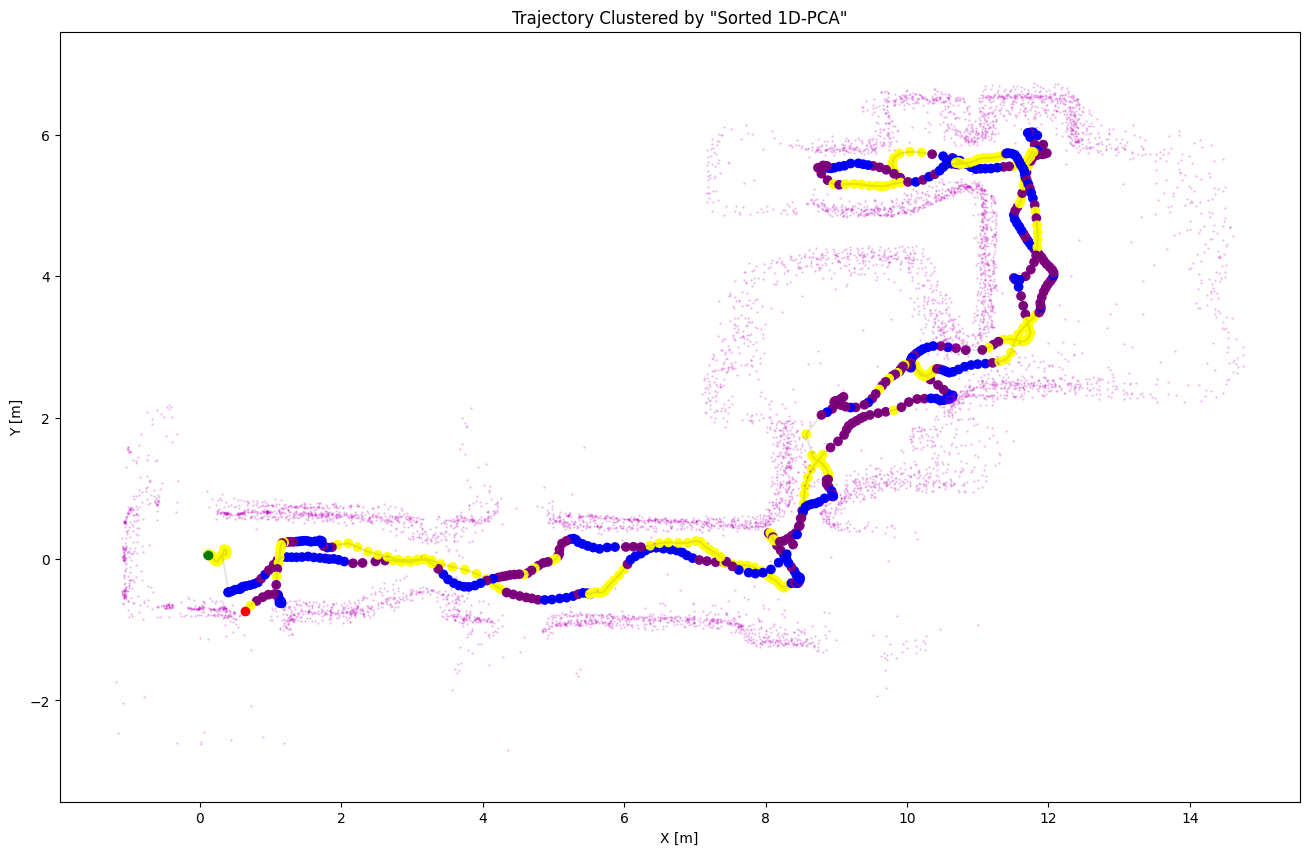

In [132]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from scipy.spatial.distance import jensenshannon

# --- 1. The Strategy: Sort by First Principal Component ---
# Project the scaled ranges down to a single dimension (1D)
pca_1d = PCA(n_components=1)
ranges_1d = pca_1d.fit_transform(scaler.transform(ranges)).flatten()

# Get the indices that would sort this 1D array
sorted_indices = np.argsort(ranges_1d)

# Create an empty label array
labels_sorted = np.zeros_like(ranges_1d, dtype=int)
N = len(ranges_1d)

# Assign labels based on the sorted position (33% chunks)
# Chunk 1: Class 0
labels_sorted[sorted_indices[:N//3]] = 0
# Chunk 2: Class 1
labels_sorted[sorted_indices[N//3 : 2*N//3]] = 1
# Chunk 3: Class 2
labels_sorted[sorted_indices[2*N//3:]] = 2

# --- 2. Calculate the Metrics (Spatial Error & Uniformity) ---

# Metric A: Spatial Consistency (KNN on x,y)
X_loc = np.vstack((x, y)).T
Y_target = labels_sorted
Y_target_reshaped = np.expand_dims(Y_target, axis=1)

knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_loc, Y_target_reshaped)
Y_pred = knn_model.predict(X_loc)

# Error is 1 if prediction (rounded) doesn't match actual label
err_vec = np.round(Y_pred) != Y_target_reshaped
spatial_error = np.sum(err_vec) / N

# Metric B: Distribution Uniformity (Jensen-Shannon)
# Calculate actual probabilities
counts = [np.sum(Y_target == i) for i in [0, 1, 2]]
p_actual = np.array(counts) / N
p_uniform = [1/3, 1/3, 1/3]
js_dist = jensenshannon(p_uniform, p_actual)

# --- 3. Results ---
print(f"Strategy: PCA-1D Sorting")
print(f"Class Counts: {counts}")
print(f"Jensen-Shannon Distance (Balance Error): {js_dist:.4f} (Should be ~0.0)")
print(f"Spatial Neighbor Error: {spatial_error:.4f}")

# Optional: Compare with previous 'err' if available in your variables
print(f"Improvement in Spatial Error: {abs(spatial_error - err)*100/err:.2f}%")

# --- 4. Visualization ---

# Define colors for the 3 classes (e.g., yellow, purple, Blue)
colors_map = np.array(['yellow', 'purple', 'blue'])
# Map the labels to actual color strings
point_colors = colors_map[labels_sorted]

# Subsample for plotting (every 31st point) to match previous plots
sub_idx = slice(None, None, 31)

plt.figure(figsize=(16, 10), dpi=100)

# 1. Background: Point Cloud
plt.plot(pc_x_r_[valid_inds_bool_][sub_idx], 
         pc_y_r_[valid_inds_bool_][sub_idx], 
         'm.', markersize=1, alpha=0.3)

# 2. Trajectory Line (to show continuity)
plt.plot(x[sub_idx], y[sub_idx], 'k-', alpha=0.1)

# 3. Trajectory Points (Colored by our new balanced classes)
plt.scatter(x[sub_idx], y[sub_idx], c=point_colors[sub_idx])

# 4. Markers
plt.scatter([x[0]], [y[0]], c='green')
plt.scatter([x[-1]], [y[-1]], c='red')

plt.title('Trajectory Clustered by "Sorted 1D-PCA"')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.axis('equal')
plt.show()